In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import math
from scipy import signal
from scipy.fftpack import fft
from scipy import ndimage
from scipy import special
import math
import time as toc
import random
%matplotlib inline

In [2]:
def STconvolve(x,k,dx,dt):
    output = np.zeros_like(x)
    for i in range(x.shape[0]):
        for ii in np.arange(max(i-k.shape[0]+1, 0), i+1):
            output[i,:] += np.convolve(x[ii,:],k[i-ii, :],'same')*dx*dt
    return output

# activation function
def NL(inp, theta = 0):
    y = inp.copy()
    y[y<theta] = theta
    return y-theta
def Gaussian_filter_1d(x,s):
    return(np.exp(-(x/s)**2/2))/s/np.sqrt(np.pi*2)

In [3]:
def Retina_Mechine_1D(stimulus, sigma_dict, para_dict, dx, dt, loc_dict = 1):
    if loc_dict == 1:
        loc_dict = {}
        loc_dict['C'] = 1
        loc_dict['H'] = 1
        
    klen = max(sigma_dict.values())*5
    xx = np.arange(-klen,klen,dx)
    KC = Gaussian_filter_1d(xx,sigma_dict['C'])
    KH = Gaussian_filter_1d(xx,sigma_dict['H'])

    output = np.zeros_like(stimulus)#y output
    zts = np.zeros_like(stimulus)#horizontal
    sstm = np.zeros_like(stimulus)
    rpeak = np.zeros(np.shape(stimulus)[0])
    
    if 'tau_y' in sigma_dict.keys():
        T = np.arange(0,int(sigma_dict['tau_y']/dt*8))*dt
        Ky=T/sigma_dict['tau_y'] /sigma_dict['tau_y'] *np.exp(-T/sigma_dict['tau_y'])
#         plt.plot(T,Ky)
        for j in range(np.shape(stimulus)[1]):
            for i in range(len(Ky)-1):
                for ii in range(i+1):
                    sstm[i,j] += stimulus[ii,j]*Ky[i-ii]*dt
            sx = np.convolve(stimulus[:,j],Ky,'valid')*dt
            sstm[len(Ky)-1:,j] = sx.copy()
    else:
        sstm = stimulus.copy()

    for i in range(np.shape(stimulus)[0]-1):
        s = sstm[i,:]
        rs = np.convolve(s,KC,'same')*dx
        ry = np.convolve(output[i,:],KH,'same')*dx  # feedback from horizontal cell (y convoluted with horitonatl cell receptive field KH)
        rz = np.convolve(zts[i,:],KH,'same')*dx     # feedback from horizontal cell (z convoluted with horitonatl cell receptive field KH)

        dyj =(-para_dict['alpha']*output[i,:]+para_dict['k']*(rs-para_dict['phi']*rz))
        dzj =(-para_dict['beta']*zts[i,:]+para_dict['g']*output[i,:])
        output[i+1,:] = (output[i,:]+dyj*dt)*loc_dict['C']
        zts[i+1,:] = (zts[i,:]+dzj*dt)*loc_dict['H']
        
        maxpos = np.argmax(output[i+1,:])
        rpeak[i+1]= maxpos*dx
    return output, zts, rpeak

def FB_FF_1l_1D(stimulus, sigma_dict, para_dict, dx, dt, loc_dict = 1):
    if loc_dict == 1:
        loc_dict = {}
        loc_dict['C'] = 1
        loc_dict['H'] = 1
        
    klen = min(max(sigma_dict.values())*3, int(stimulus.shape[1]/2/dx))
    xx = np.arange(-klen,klen+dx,dx)
    KC = Gaussian_filter_1d(xx,sigma_dict['C'])
    KH = Gaussian_filter_1d(xx,sigma_dict['H'])
    KB = Gaussian_filter_1d(xx,sigma_dict['B'])
#     plt.plot(KC)
#     plt.plot(KH)
#     plt.plot(KB)
#     plt.plot(KC-KH)
    
    output = np.zeros_like(stimulus)#y output
    zts = np.zeros_like(stimulus)#horizontal
    yts = np.zeros_like(stimulus)#horizontal
    wts = np.zeros_like(stimulus)#horizontal
    sstm = np.zeros_like(stimulus)
    rpeak1 = np.zeros(np.shape(stimulus)[0])
    rpeak2 = np.zeros(np.shape(stimulus)[0])
    rinvertpeak2 = np.zeros(np.shape(stimulus)[0])
    
    if 'tau_y' in sigma_dict.keys():
        T = np.arange(0,int(sigma_dict['tau_y']/dt*8))*dt
        Ky=T/sigma_dict['tau_y'] /sigma_dict['tau_y'] *np.exp(-T/sigma_dict['tau_y'])
        for j in range(np.shape(stimulus)[1]):
            for i in range(len(Ky)-1):
                for ii in range(i+1):
                    sstm[i,j] += stimulus[ii,j]*Ky[i-ii]*dt
            sx = np.convolve(stimulus[:,j],Ky,'valid')*dt
            sstm[len(Ky)-1:,j] = sx.copy()
    else:
        sstm = stimulus.copy()

    for i in range(np.shape(stimulus)[0]):
        s = sstm[i,:]
        rs = np.convolve(s,KC,'same')*dx
        ry2z = np.convolve(yts[i-1,:],KH,'same')*dx# feedback from horizontal cell (y convoluted with horitonatl cell receptive field KH)
        dyj =(-para_dict['alpha']*yts[i-1,:]+para_dict['k']*(rs-para_dict['phi']*zts[i-1,:]))*dt
        dzj =(-para_dict['beta']*zts[i-1,:]+para_dict['g']*ry2z)*dt
                
        yts[i,:] = (yts[i-1,:]+dyj)*loc_dict['C']
        zts[i,:] = (zts[i-1,:]+dzj)*loc_dict['H']
        ry2w = np.convolve(yts[i-1,:],KB,'same')*dx# feedback from horizontal cell (y convoluted with horitonatl cell receptive field KH)
        dwj =(-para_dict['gramma']*wts[i-2,:]+para_dict['p']*((1-para_dict['psy'])*ry2w-para_dict['psy']*zts[i-1,:]))*dt

        wts[i-1,:] = (wts[i-2,:]+dwj)
        maxpos1 = np.argmax(yts[i,:])
        rpeak1[i]= maxpos1*dx
        maxpos2 = np.argmax(wts[i-1,:])
        rpeak2[i-1]= maxpos2*dx
        maxipos2 = np.argmin(wts[i-1,:])
        rinvertpeak2[i-1]= maxipos2*dx
    
    ry2w = np.convolve(yts[i,:],KB,'same')*dx# feedback from horizontal cell (y convoluted with horitonatl cell receptive field KH)
    dwj =(-para_dict['gramma']*wts[i-1,:]+para_dict['p']*((1-para_dict['psy'])*ry2w-para_dict['psy']*zts[i,:]))*dt
    wts[i,:] = (wts[i-1,:]+dwj)
    maxpos2 = np.argmax(wts[i,:])
    rpeak2[i]= maxpos2*dx
    maxipos2 = np.argmin(wts[i,:])
    rinvertpeak2[i]= maxipos2*dx
    return wts, zts, yts, rpeak1, rpeak2, rinvertpeak2

## parameters

In [4]:
filename = 'CKC STkernels-good parameters'

NGD_sigma_dict = dict()
NGD_sigma_dict['H'] = 1
NGD_sigma_dict['C'] = NGD_sigma_dict['H']*0.1 # RF size of cone cell
dx = NGD_sigma_dict['H']/40.

dt=0.01  #large dt will cause  overflow
nstep = int(1.6/dt)
NGD_sigma_dict['tau_y'] = 0.02
#Width settingw
xlen = 50*NGD_sigma_dict['H'] #spatial extend of simulation
Dynamical_range = 6*NGD_sigma_dict['H']/dx #188-16 pixels
hw = 3*Dynamical_range*dx/22 #half bar width  #8 pixels
tempx = np.arange(0,xlen/dx+1)*dx

NGD_para_dict = {}
NGD_para_dict['alpha'] = 30. 
NGD_para_dict['beta'] = 1.2
NGD_para_dict['k'] = 20. #not important if there is no adaption
NGD_para_dict['phi'] = 1.
NGD_para_dict['g'] = 30. #but k*g are important


FBFF_sigma_dict = NGD_sigma_dict.copy()
FBFF_para_dict = NGD_para_dict.copy()
FBFF_para_dict['gramma'] = 100.
FBFF_para_dict['p'] = 100. # not important if there is no adaption
FBFF_para_dict['psy'] = 0.1

FBFF_sigma_dict['B'] = FBFF_sigma_dict['H']*0.5



# Spatio temporal Stimuli

## moving bar

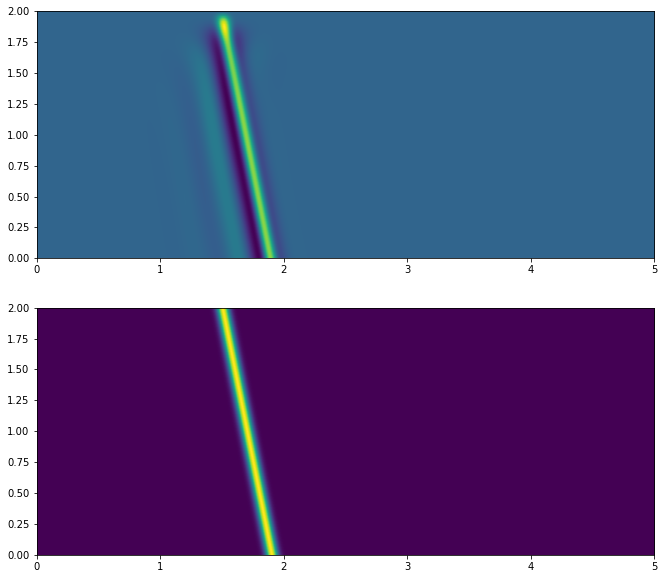

In [5]:
hbarwid = 100
ssigma = 20
moving_bar = np.zeros([nstep, int(xlen/dx)+1])
v = 1 #xstep/tstep
pos = 600
speak = np.zeros(nstep)
t_mb=np.arange(dt,1.6+1e-5,dt)
for i in range(nstep):
    pos = pos+v
    for ii in range(int(xlen/dx)+1):
        moving_bar[i, ii] = np.exp(-((ii-pos)/ssigma)**2)

wts, zts, yts,_,_,_ = FB_FF_1l_1D(moving_bar, FBFF_sigma_dict, FBFF_para_dict, dx, dt, loc_dict = 1)
pos
fig,ax=plt.subplots(2,1)
ax[1].imshow(moving_bar,extent=[0,5,0,2])
ax[0].imshow(yts,extent=[0,5,0,2])
fig.set_size_inches(15, 10)

## low-pass OU
gaussian pulse and bar

importing Jupyter notebook from NGDfunc.ipynb


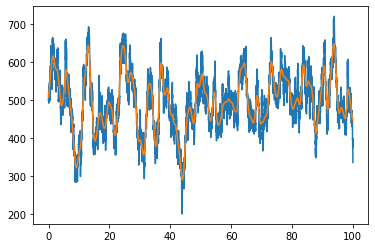

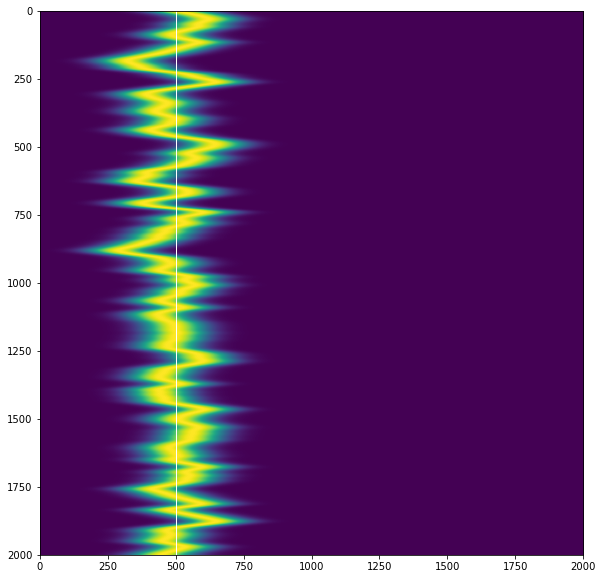

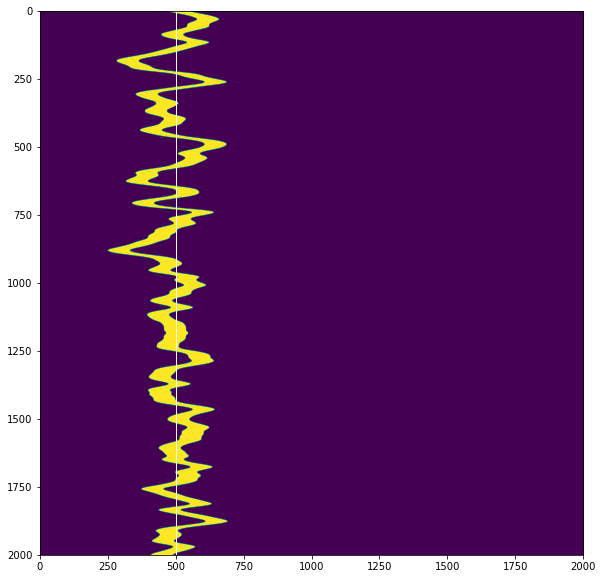

In [6]:
import os
os.chdir('F:/我的雲端硬碟/Retina exp/python code/functions')
import import_ipynb
import NGDfunc

tau_ou=1
fc=0.5
T_ou=100
nsteps_ou=int(T_ou/dt)
mid_pos=500
randseed = np.random.normal(0, 50, nsteps_ou)
time_ou,x_ou=NGDfunc.OU(T_ou,tau_ou,'no',dt,randseed)
time_ou,x_lpou=NGDfunc.OU(T_ou,tau_ou,fc,dt,randseed)
x_ou=x_ou+mid_pos
x_lpou=x_lpou+mid_pos
plt.plot(time_ou,x_ou)
plt.plot(time_ou,x_lpou)
plt.xlim()
plt.show()

lpou_gaussian_ST=np.zeros((nsteps_ou-1,int(xlen/dx)))
lpou_bar_ST=np.zeros((nsteps_ou-1,int(xlen/dx)))
x_global=np.arange(0,int(xlen/dx),1)
ssigma=80 # gaussian bar sigma
bw=81 # bar width
for i in range(nsteps_ou-1):
    lpou_gaussian_ST[i,:]=np.exp(-(x_global-x_lpou[i])**2/ssigma**2/2)/ssigma/np.sqrt(2*math.pi)
    lpou_bar_ST[i,int(round(x_lpou[i])-(bw-1)/2):int(round(x_lpou[i])+(bw-1)/2)+1]=np.ones(bw)
    
plt.imshow(lpou_gaussian_ST, extent=[0,2000,T_ou*20,0])
plt.axvline(x=500,c='w',linewidth=1)
plt.gcf().set_size_inches(15, 10)
plt.show()

plt.imshow(lpou_bar_ST, extent=[0,2000,T_ou*20,0])
plt.axvline(x=500,c='w',linewidth=1)
plt.gcf().set_size_inches(15, 10)
plt.show()


(400.0, 600.0)

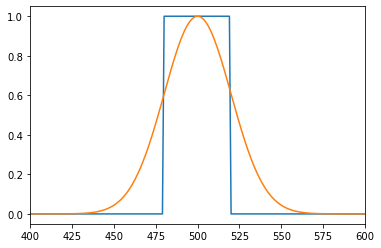

In [7]:
xxx=np.arange(0,1000)
y1=np.zeros(len(xxx))
y1[480:520]=1
y2=np.exp(-(xxx-500)**2/20**2/2)
plt.plot(y1)
plt.plot(y2)
plt.xlim(400,600)

## OU output (gaussian)

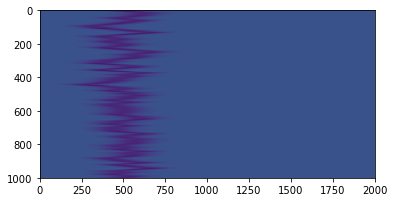

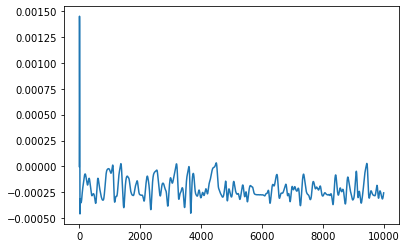

In [8]:
wts, zts, yts,_,_,_ = FB_FF_1l_1D(lpou_gaussian_ST, FBFF_sigma_dict, FBFF_para_dict, dx, dt, loc_dict = 1)
plt.imshow(wts,extent=[0,2000,T_ou*10,0])
plt.show()
# ===select one cell (index 500)===
output_cell=wts[:,500]
output_cell_rectified=NL(output_cell)
plt.plot(output_cell)

### MI

NGDfunc.ipynb:48: RuntimeWarning: invalid value encountered in true_divide
  "    yedges=np.arange(min(ystate),max(ystate)+0.0001)\n",


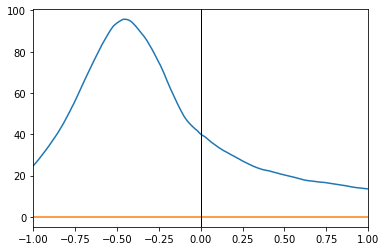

In [9]:
x_lpou_state=NGDfunc.EqualState(x_lpou,8)
out_cell_state=NGDfunc.EqualState(output_cell,8)
out_cell_rec_state=NGDfunc.EqualState(output_cell_rectified,8)
tl_lpou,MI_lpou=NGDfunc.MI(x_lpou_state,out_cell_state,dt,[-3,3])
tl_lpou,MI_lpou_rec=NGDfunc.MI(x_lpou_state,out_cell_rec_state,dt,[-3,3])
plt.plot(tl_lpou,MI_lpou)
plt.plot(tl_lpou,MI_lpou_rec)
plt.xlim(-1,1)
plt.axvline(x=0,c='k',linewidth=1)

# OU input with different $\psi$ in the model

## OU input (gaussian pulse)

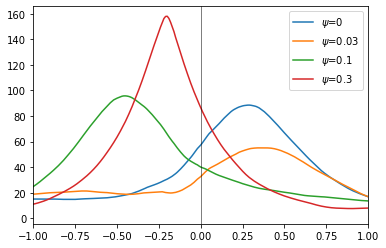

In [10]:
psy_set=[0,0.03,0.1,0.3] #psy_set=[0.1]
output_psi_set=[[] for i in range(len(psy_set))]
MI_psi_set=[[] for i in range(len(psy_set))]
for i in range(np.size(psy_set)):
    FBFF_para_dict['psy']=psy_set[i]
    wts,_,_,_,_,_ = FB_FF_1l_1D(lpou_gaussian_ST, FBFF_sigma_dict, FBFF_para_dict, dx, dt, loc_dict = 1)
    out=wts[:,500]
#     output_psi_set[i]=NL(out)
    output_psi_set[i]=out
    tl,MI_psi_set[i]=NGDfunc.MI(NGDfunc.EqualState(x_lpou,8),NGDfunc.EqualState(output_psi_set[i],8),dt,[-3,3])
for i in range(len(psy_set)):
    plt.plot(tl,MI_psi_set[i],label='$\psi$='+str(psy_set[i]))
plt.xlim(-1,1)
plt.axvline(x=0,c='k',linewidth=0.5)
plt.legend()

## OU input (square bar)

In [11]:
# psy_set=[0,0.05,0.1,0.3] #psy_set=[0.1]
# output_psi_set=[[] for i in range(len(psy_set))]
# MI_psi_set=[[] for i in range(len(psy_set))]
# for i in range(np.size(psy_set)):
#     FBFF_para_dict['psy']=psy_set[i]
#     wts,_,_,_,_,_ = FB_FF_1l_1D(lpou_bar_ST, FBFF_sigma_dict, FBFF_para_dict, dx, dt, loc_dict = 1)
#     out=wts[:,500]
# #     output_psi_set[i]=NL(out)
#     output_psi_set[i]=out
#     tl,MI_psi_set[i]=NGDfunc.MI(NGDfunc.EqualState(x_lpou,8),NGDfunc.EqualState(output_psi_set[i],8),dt,[-3,3])
# for i in range(len(psy_set)):
#     plt.plot(tl,MI_psi_set[i],label='$\psi$='+str(psy_set[i]))
# plt.xlim(-1,1)
# plt.axvline(x=0,c='k',linewidth=0.5)
# plt.legend()

## generating Poisson spikes (using gaussian pulse output)

In [18]:
def Poisson_spike(FR_input,threshold,dt,onoff_mode='on'):
    if onoff_mode=='on':
        k=2
    elif onoff_mode=='off':
        k=1
    rtemp=(-1)**k*(FR_input-threshold)
    rtemp[rtemp<0]=0
    rtemp=rtemp*20000 # make the response similar to real firing rate
    print(np.mean(rtemp))
    tempspikes=np.zeros(len(rtemp))
    for step in range(len(rtemp)):
        if random.random()<rtemp[step]*dt:
            tempspikes[step]=1
        else:
            tempspikes[step]=0
    return tempspikes,rtemp

0.28786870426921335


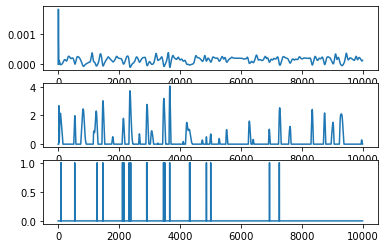

In [23]:
sp,r=Poisson_spike(output_psi_set[1],0,0.01,'off')
fig,ax=plt.subplots(3,1)
ax[0].plot(output_psi_set[0])
ax[1].plot(r)
ax[2].plot(sp)
ax[0].set_xlim(2000,3000)
ax[1].set_xlim(2000,3000)
ax[2].set_xlim(2000,3000)

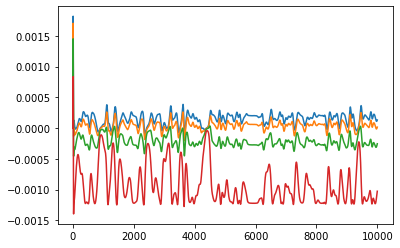

In [24]:
for i in range(4):
    plt.plot(output_psi_set[i])